In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import itertools
import logging
from scipy.stats import norm 

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"D:\Minor Project\All Models\Interval_Forecast_Quantile\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Open', 'High', 'Low', 'Carbon_Price_USD', 'Vol.', 'Change %'],
    
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "param_grid": {
        'seq_len': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'hidden_dim': [32, 64, 128, 256],
        'num_layers': [2, 3, 4],
        'kernel_size': [2, 3, 4, 5],
        'learning_rate': [0.005, 0.01],
        'epochs': [100]

        # 'seq_len': [1],
        # 'hidden_dim': [256],
        # 'num_layers': [2],
        # 'kernel_size': [5],
        # 'learning_rate': [0.01],
        # 'epochs': [100]
    }
}

# --- 2. Model Definition (Custom TCN) ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous() if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.drop1,
            self.conv2, self.chomp2, self.relu2, self.drop2
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else None
        self.out_relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.out_relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            padding = (kernel_size - 1) * dilation
            layers.append(
                TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                              dilation=dilation, padding=padding, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, kernel_size, dropout=0.2):
        super().__init__()
        num_channels = [hidden_dim] * num_layers
        self.tcn = TCN(num_inputs=input_dim,
                           num_channels=num_channels,
                           kernel_size=kernel_size,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, seq, feat) -> (B, feat, seq)
        y = self.tcn(x)         # (B, hidden, seq)
        last = y[:, :, -1]      # last timestep
        return self.fc(last)

# --- 3. Pipeline Functions ---
def load_and_clean_data(file_path):
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)

    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except:
                return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_quantile_model(X_train, y_train, quantile, params):
    model = TCNQuantile(
        input_dim=X_train.shape[2], 
        hidden_dim=params['hidden_dim'], 
        num_layers=params['num_layers'],
        kernel_size=params['kernel_size']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    def quantile_loss(q, y, y_pred):
        e = y - y_pred
        return torch.mean(torch.max(q * e, (q - 1) * e))

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])

        if len(X_val_seq) == 0: continue

        lower_model = train_quantile_model(X_train_seq, y_train_seq, 0.025, params)
        upper_model = train_quantile_model(X_train_seq, y_train_seq, 0.975, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pred_lower_s = lower_model(X_val_t).cpu().numpy()
            pred_upper_s = upper_model(X_val_t).cpu().numpy()

        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        pred_upper = np.maximum(pred_lower, pred_upper)
        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold on the validation set.")
        
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    lower_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.025, best_params)
    upper_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.975, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pred_lower_s = lower_model(X_test_t).cpu().numpy()
        pred_upper_s = upper_model(X_test_t).cpu().numpy()

    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_upper = np.maximum(pred_lower, pred_upper)
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)

    results = {"picp": final_picp, "mpiw": final_mpiw}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    
    return results, plot_data

def plot_results(plot_data, test_dates):
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]

    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                       color='dodgerblue', alpha=0.3, label=f'Prediction Interval')

    plt.title('Final Model Evaluation on Test Set')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print("="*40 + "\n")
    
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()


2025-08-26 16:59:07,268 - INFO - Loading data from D:\Minor Project\All Models\Interval_Forecast_Quantile\df_without_exo.xlsx...


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Minor Project\\All Models\\Interval_Forecast_Quantile\\df_without_exo.xlsx'

In [2]:
!pip install torch

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 1.0/241.3 MB 5.8 MB/s eta 0:00:42
   ---------------------------------------- 2.1/241.3 MB 5.6 MB/s eta 0:00:43
    --------------------------------------- 3.4/241.3 MB 5.7 MB/s eta 0:00:42
    --------------------------------------- 4.5/241.3 MB 5.6 MB/s eta 0:00:43
    --------------------------------------- 5.8/241.3 MB 5.7 MB/s eta 0:00:42
   - -------------------------------------- 6.8/241.3 MB 5.7 MB/s eta 0:00:42
   - -------------------------------------- 8.1/241.3 MB 5.7 MB/s eta 0:00:41
   - -------------------------------------- 9.2/241.3 MB 5.7 MB/s eta 0:00:41
   - -------------------------------------- 10.2/241.3 MB 5.7 MB/s eta 0:00:41
   - -------------------------------------- 11.5/241.3 MB 5.7 MB/s eta 0:00:41
   -- ------------------------------------- 12.6/241.3 MB 5.7 MB/s eta 0:00:41
   -- ------------------------------------- 13.9/241.3 MB 5.7 MB/s e

2025-08-24 22:39:48,737 - INFO - Loading data from D:\Minor Project\All Models\Interval_Forecast_Quantile\df_without_exo.xlsx...
2025-08-24 22:39:48,834 - INFO - Engineering lagged features...
2025-08-24 22:39:48,837 - INFO - Splitting test data at date: 2024-04-01
2025-08-24 22:39:48,842 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-24 22:39:48,854 - INFO - Starting hyperparameter search over 960 combinations...
2025-08-24 22:39:50,081 - INFO - ✗ Model rejected: PICP=93.98% with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.005, 'epochs': 100}
2025-08-24 22:39:51,409 - INFO - ✓ Valid model found: PICP=96.39%, MPIW=12.7842 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 2, 'learning_rate': 0.01, 'epochs': 100}
2025-08-24 22:39:52,834 - INFO - ✓ Valid model found: PICP=95.18%, MPIW=11.9189 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 2, 'kernel_size': 3, 'learning_rate': 0.0


Best Hyperparameters: {'seq_len': 8, 'hidden_dim': 64, 'num_layers': 3, 'kernel_size': 4, 'learning_rate': 0.005, 'epochs': 100}
Prediction Interval Coverage (PICP): 97.53%
Mean Prediction Interval Width (MPIW): 12.7729
Continuous Ranked Probability Score (CRPS): 1.4422



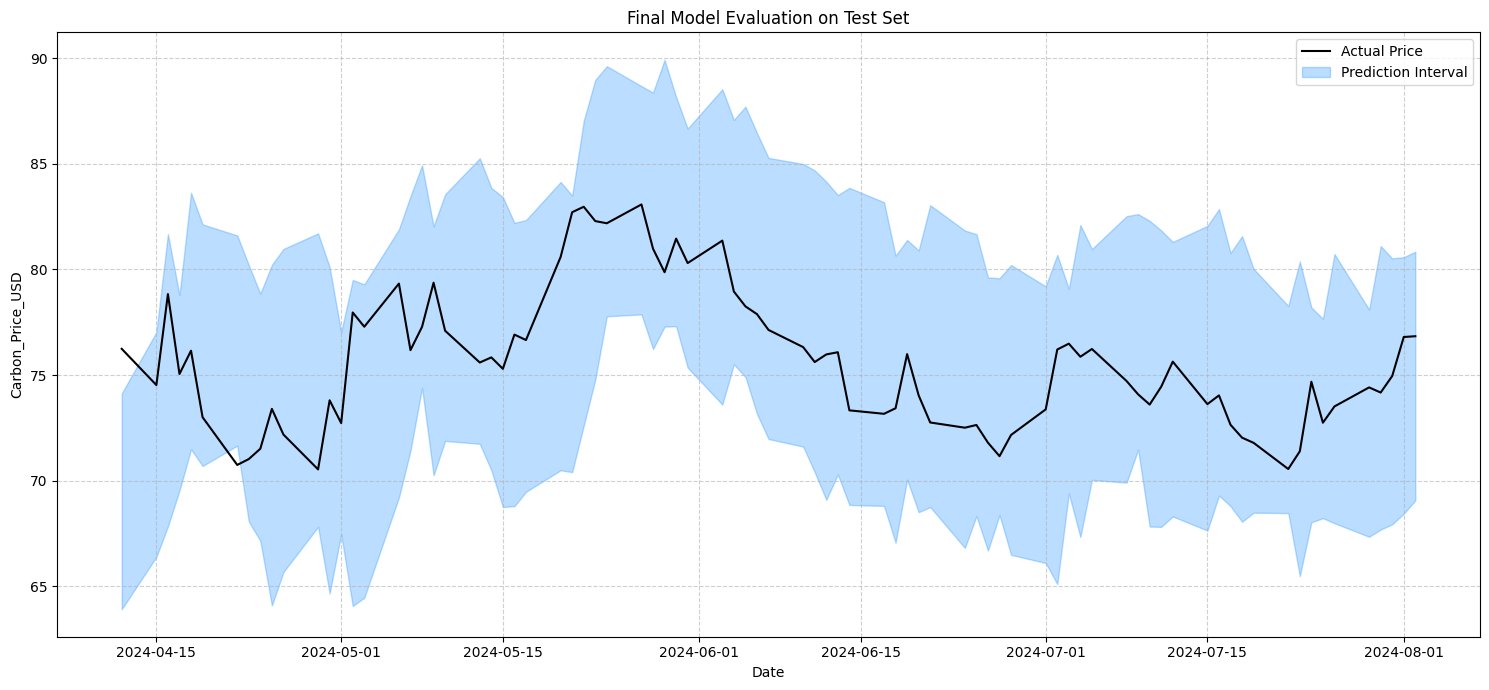

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import itertools
import logging
from scipy.stats import norm 

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"D:\Minor Project\All Models\Interval_Forecast_Quantile\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Carbon_Price_USD'],
    
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "param_grid": {
        'seq_len': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'hidden_dim': [32, 64, 128, 256],
        'num_layers': [2, 3, 4],
        'kernel_size': [2, 3, 4, 5],
        'learning_rate': [0.005, 0.01],
        'epochs': [100]

        # 'seq_len': [1],
        # 'hidden_dim': [256],
        # 'num_layers': [2],
        # 'kernel_size': [5],
        # 'learning_rate': [0.01],
        # 'epochs': [100]
    }
}

# --- 2. Model Definition (Custom TCN) ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous() if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.drop1,
            self.conv2, self.chomp2, self.relu2, self.drop2
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else None
        self.out_relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.out_relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            padding = (kernel_size - 1) * dilation
            layers.append(
                TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                              dilation=dilation, padding=padding, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, kernel_size, dropout=0.2):
        super().__init__()
        num_channels = [hidden_dim] * num_layers
        self.tcn = TCN(num_inputs=input_dim,
                           num_channels=num_channels,
                           kernel_size=kernel_size,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, seq, feat) -> (B, feat, seq)
        y = self.tcn(x)         # (B, hidden, seq)
        last = y[:, :, -1]      # last timestep
        return self.fc(last)

# --- 3. Pipeline Functions ---
def load_and_clean_data(file_path):
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)

    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except:
                return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_quantile_model(X_train, y_train, quantile, params):
    model = TCNQuantile(
        input_dim=X_train.shape[2], 
        hidden_dim=params['hidden_dim'], 
        num_layers=params['num_layers'],
        kernel_size=params['kernel_size']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    def quantile_loss(q, y, y_pred):
        e = y - y_pred
        return torch.mean(torch.max(q * e, (q - 1) * e))

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])

        if len(X_val_seq) == 0: continue

        lower_model = train_quantile_model(X_train_seq, y_train_seq, 0.025, params)
        upper_model = train_quantile_model(X_train_seq, y_train_seq, 0.975, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pred_lower_s = lower_model(X_val_t).cpu().numpy()
            pred_upper_s = upper_model(X_val_t).cpu().numpy()

        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        pred_upper = np.maximum(pred_lower, pred_upper)
        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold on the validation set.")
        
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    lower_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.025, best_params)
    upper_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.975, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pred_lower_s = lower_model(X_test_t).cpu().numpy()
        pred_upper_s = upper_model(X_test_t).cpu().numpy()

    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_upper = np.maximum(pred_lower, pred_upper)
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)

    results = {"picp": final_picp, "mpiw": final_mpiw}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    
    return results, plot_data

def plot_results(plot_data, test_dates):
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]

    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                       color='dodgerblue', alpha=0.3, label=f'Prediction Interval')

    plt.title('Final Model Evaluation on Test Set')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print("="*40 + "\n")
    
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()
